In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets


from lightgbm import LGBMClassifier
import lightgbm as lbg
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc

import re

dataset = pd.read_csv("train_feat_eng.csv")

num_dataset = pd.get_dummies(dataset)

In [158]:
from matplotlib      import pyplot as plt
from IPython.display import display
import joblib

In [149]:
data = num_dataset.drop('TARGET', 1)
target = num_dataset['TARGET']

X_train, X_test, y_train, y_test = train_test_split(data,target ,test_size = .2, random_state=42,shuffle=True)

train_data = lbg.Dataset(X_train,y_train)
test_data = lbg.Dataset(X_test,y_test)

PARAMS = {'max_depth':4,
          'num_leaves':16,
          'bagging_fraction':1,
          'feature_fraction':1,
          'boosting':'dart',
          'num_iterations':300,
          
          'objective':'binary',
          'metric':'auc',
          'is_unbalance':True,
          'verbose':10
          }
PARAMSD = {}


In [150]:
model = lbg.train(PARAMS,train_data,valid_sets=test_data)

pred = model.predict(X_test)

C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.700101
[2]	valid_0's auc: 0.71614
[3]	valid_0's auc: 0.722688
[4]	valid_0's auc: 0.725351
[5]	valid_0's auc: 0.727897
[6]	valid_0's auc: 0.729354
[7]	valid_0's auc: 0.731324
[8]	valid_0's auc: 0.731114
[9]	valid_0's auc: 0.731864
[10]	valid_0's auc: 0.733152
[11]	valid_0's auc: 0.734256
[12]	valid_0's auc: 0.734001
[13]	valid_0's auc: 0.735046
[14]	valid_0's auc: 0.736147
[15]	valid_0's auc: 0.736836
[16]	valid_0's auc: 0.738745
[17]	valid_0's auc: 0.739772
[18]	valid_0's auc: 0.740555
[19]	valid_0's auc: 0.741396
[20]	valid_0's auc: 0.742322
[21]	valid_0's auc: 0.742229
[22]	valid_0's auc: 0.742738
[23]	valid_0's auc: 0.743193
[24]	valid_0's auc: 0.744661
[25]	valid_0's auc: 0.745276
[26]	valid_0's auc: 0.746323
[27]	valid_0's auc: 0.746935
[28]	valid_0's auc: 0.746853
[29]	valid_0's auc: 0.747423
[30]	valid_0's auc: 0.747698
[31]	valid_0's auc: 0.747584
[32]	valid_0's auc: 0.748402
[33]	valid_0's auc: 0.749081
[34]	valid_0's auc: 0.749503
[35]	valid_0's auc: 0.74

In [112]:
### GRID SEARCH WIP ###
SEARCH_PARAMS = {'max_depth':[3,4,8,16,-1],
                 'num_leaves':[8,16,32,64,256],
                 'bagging_fraction':[1],
                 'feature_fraction':[1],
                 'boosting':['dart','gbdt'],
                 'num_iterations':[100,300,500],
                 'objective':['binary'],
                 'metric':['auc'],
                 'is_unbalance':[True],
                 
                }


lb = lbg.LGBMClassifier()
clf = GridSearchCV(lb,SEARCH_PARAMS,cv = 3,verbose=10,scoring='roc_auc')
clf.fit(data,target)

sorted(clf.cv_results_.keys())

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.747, total=   5.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.743, total=   5.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.749, total=   5.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.747, total=   5.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.0s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.743, total=   5.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.2s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.749, total=   5.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.3s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.747, total=   5.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   36.4s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.743, total=   5.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.8s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.749, total=   5.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   47.5s remaining:    0.0s
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.747, total=   5.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.743, total=   5.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.749, total=   5.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.747, total=   5.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.743, total=   5.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.749, total=   5.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.760, total=  13.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.755, total=  13.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.757, total=  13.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.760, total=  13.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.755, total=  14.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.757, total=  14.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.760, total=  14.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.755, total=  13.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.757, total=  14.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.760, total=  13.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.755, total=  13.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.757, total=  13.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.760, total=  14.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.755, total=  13.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.757, total=  14.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.763, total=  24.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.760, total=  25.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.759, total=  24.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.763, total=  25.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.760, total=  25.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.759, total=  24.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.763, total=  26.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.760, total=  26.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.759, total=  25.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.763, total=  26.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.760, total=  25.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.759, total=  24.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.763, total=  25.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.760, total=  24.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.759, total=  25.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.750, total=   5.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.746, total=   6.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.750, total=   6.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.752, total=   6.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.748, total=   6.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.754, total=   6.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.752, total=   6.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.748, total=   9.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.754, total=   7.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.752, total=   7.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.748, total=   7.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.754, total=   7.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.752, total=   7.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.748, total=   8.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.754, total=   7.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.762, total=  21.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.757, total=  19.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.760, total=  19.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.762, total=  21.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.758, total=  19.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.757, total=  20.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.762, total=  19.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.758, total=  19.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.757, total=  20.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.762, total=  19.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.758, total=  20.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.757, total=  20.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.762, total=  19.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.758, total=  19.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.757, total=  20.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.767, total=  33.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.762, total=  33.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.766, total=  33.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.762, total=  40.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.762, total=  35.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.760, total=  36.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.762, total=  39.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.762, total=  38.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.760, total=  35.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.762, total=  35.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.762, total=  36.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.760, total=  38.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.762, total=  39.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.762, total=  35.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.760, total=  33.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.751, total=   6.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.747, total=   5.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.751, total=   6.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.756, total=   7.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.753, total=   7.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.754, total=   7.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.759, total=   9.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.755, total=   9.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.754, total=  10.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.760, total=  12.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.755, total=  12.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.747, total=  13.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.751, total=  16.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.750, total=  17.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.729, total=  16.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=  18.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.758, total=  18.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.759, total=  17.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.767, total=  25.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.762, total=  25.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.760, total=  25.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.767, total=  33.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.763, total=  33.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.757, total=  33.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.761, total=  40.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.762, total=  42.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.749, total=  40.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.745, total=  54.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.753, total=  59.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.727, total=  59.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.767, total=  34.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.763, total=  33.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.765, total=  33.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.769, total=  46.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.765, total=  44.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.764, total=  45.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.766, total=  59.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.764, total=  59.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.761, total=  59.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.754, total= 1.2min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.760, total= 1.3min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.745, total= 1.3min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.738, total= 1.7min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.751, total= 1.7min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.733, total= 1.7min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.751, total=   6.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.747, total=   6.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.751, total=   6.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.756, total=   7.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.753, total=   8.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.751, total=   7.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.760, total=  10.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.756, total=  10.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.754, total=  10.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.760, total=  13.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.757, total=  14.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.746, total=  13.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.753, total=  26.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.752, total=  27.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.741, total=  27.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=  18.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.758, total=  17.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.759, total=  18.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.766, total=  25.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.762, total=  26.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.757, total=  24.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.767, total=  32.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.764, total=  32.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.760, total=  31.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.765, total=  42.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.762, total=  42.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.751, total=  43.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.753, total= 1.4min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.755, total= 1.5min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.742, total= 1.6min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.767, total=  31.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.763, total=  31.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.765, total=  31.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.769, total=  41.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.765, total=  43.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.762, total=  42.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.767, total=  59.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.765, total= 1.0min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.761, total=  59.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.762, total= 1.3min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.762, total= 1.3min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.754, total= 1.3min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.744, total= 2.6min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.749, total= 2.5min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.741, total= 2.8min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.751, total=   6.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.747, total=   6.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.751, total=   6.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.756, total=   9.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.753, total=   8.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.751, total=   8.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.760, total=  11.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.756, total=  11.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.754, total=  10.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.760, total=  14.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.756, total=  14.9s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.748, total=  14.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.756, total=  27.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.754, total=  28.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.745, total=  28.5s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=  19.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.758, total=  18.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.759, total=  17.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.766, total=  27.2s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.762, total=  25.7s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.757, total=  28.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.767, total=  33.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.764, total=  33.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.760, total=  33.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.763, total=  45.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.762, total=  49.1s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.750, total=  45.6s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.757, total= 1.5min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.755, total= 1.6min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.745, total= 1.6min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.767, total=  35.0s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.763, total=  35.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.765, total=  35.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.769, total=  48.8s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.765, total=  49.3s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.762, total=  45.4s
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.767, total= 1.0min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.765, total= 1.1min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.763, total= 1.1min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.760, total= 1.4min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.761, total= 1.4min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.754, total= 1.4min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.749, total= 2.7min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.750, total= 2.7min
[CV] bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=dart, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.742, total= 2.8min
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.759, total=   4.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.756, total=   5.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.760, total=   5.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.759, total=   5.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.756, total=   4.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.760, total=   4.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.759, total=   4.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.756, total=   5.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.760, total=   4.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.759, total=   5.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.756, total=   4.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.760, total=   4.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.759, total=   4.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.756, total=   4.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.760, total=   4.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.760, total=   8.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=   8.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.759, total=   8.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.760, total=   8.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.763, total=   8.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.759, total=   8.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.760, total=   8.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.763, total=   8.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.759, total=   8.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.760, total=   8.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.763, total=   9.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.759, total=   9.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.760, total=   8.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.763, total=   8.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.759, total=   8.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.760, total=  12.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.765, total=  12.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.760, total=  12.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.760, total=  13.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.765, total=  12.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.760, total=  11.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.760, total=  12.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.765, total=  12.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.760, total=  14.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.760, total=  12.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.765, total=  13.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.760, total=  12.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.760, total=  12.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.765, total=  12.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=3, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.760, total=  11.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.763, total=   5.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.758, total=   5.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.761, total=   4.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.757, total=   5.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.758, total=   5.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.759, total=   5.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.757, total=   5.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.758, total=   5.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.759, total=   5.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.757, total=   5.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.758, total=   5.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.759, total=   5.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.757, total=   5.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.758, total=   5.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.759, total=   5.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.764, total=   9.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=   9.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.766, total=   9.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.753, total=  10.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.762, total=  10.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.758, total=  10.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.753, total=   9.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.762, total=   9.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.758, total=  10.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.753, total=  10.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.762, total=  10.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.758, total=  10.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.753, total=  10.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.762, total=  10.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.758, total=  10.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.761, total=  12.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.764, total=  12.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.765, total=  12.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.749, total=  14.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.762, total=  14.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.755, total=  14.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.749, total=  14.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.762, total=  14.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.755, total=  15.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.749, total=  15.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.762, total=  14.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.755, total=  15.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.749, total=  15.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.762, total=  15.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=4, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.755, total=  14.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.763, total=   5.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.758, total=   5.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.761, total=   5.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.764, total=   6.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.760, total=   6.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.759, total=   6.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.764, total=   7.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.761, total=   8.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.758, total=   8.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.755, total=   9.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.759, total=   9.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.750, total=  10.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.739, total=  11.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.751, total=  11.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.715, total=  11.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=   9.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.761, total=   9.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.764, total=   9.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.754, total=  11.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.761, total=  11.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.756, total=  11.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.750, total=  14.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.759, total=  14.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.753, total=  14.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.741, total=  18.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.753, total=  19.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.739, total=  19.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.726, total=  22.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.744, total=  23.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.710, total=  23.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.760, total=  13.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.762, total=  13.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.763, total=  13.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.750, total=  16.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.759, total=  16.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.754, total=  16.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.742, total=  20.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.754, total=  20.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.749, total=  21.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.733, total=  28.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.746, total=  28.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.729, total=  28.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.720, total=  34.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.735, total=  35.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=8, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.699, total=  34.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.763, total=   5.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.758, total=   5.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.761, total=   5.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.765, total=   7.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.761, total=   6.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.758, total=   7.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.764, total=   8.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.761, total=   8.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.753, total=   8.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.761, total=  10.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.759, total=  10.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.749, total=  10.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.743, total=  20.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.749, total=  21.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.739, total=  20.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=   9.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.761, total=   9.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.764, total=   9.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.756, total=  11.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.761, total=  12.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.758, total=  12.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.753, total=  15.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.757, total=  15.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.751, total=  15.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.743, total=  20.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.752, total=  20.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.742, total=  22.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.721, total=  45.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.728, total=  47.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.724, total=  48.1s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.760, total=  13.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.762, total=  13.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.763, total=  13.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.748, total=  16.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.760, total=  16.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.756, total=  16.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.744, total=  21.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.753, total=  22.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.747, total=  22.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.730, total=  29.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.743, total=  30.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.735, total=  30.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.716, total= 1.2min
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.722, total= 1.3min
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=16, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.716, total= 1.3min
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.763, total=   5.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.758, total=   5.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=8, objective=binary, score=0.761, total=   5.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.765, total=   7.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.761, total=   6.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=16, objective=binary, score=0.758, total=   6.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.764, total=   8.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.761, total=   9.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=32, objective=binary, score=0.754, total=   8.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.761, total=  10.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.760, total=  11.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=64, objective=binary, score=0.749, total=  10.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.745, total=  21.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.750, total=  22.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=100, num_leaves=256, objective=binary, score=0.738, total=  22.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.763, total=  10.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.761, total=   9.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=8, objective=binary, score=0.764, total=   9.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.756, total=  11.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.761, total=  12.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=16, objective=binary, score=0.758, total=  11.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.756, total=  15.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.759, total=  15.6s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=32, objective=binary, score=0.749, total=  15.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.744, total=  20.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.754, total=  20.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=64, objective=binary, score=0.743, total=  21.2s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.727, total=  46.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.734, total=  48.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=300, num_leaves=256, objective=binary, score=0.721, total=  49.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.760, total=  13.4s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.762, total=  13.5s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=8, objective=binary, score=0.763, total=  13.7s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.748, total=  17.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.760, total=  16.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=16, objective=binary, score=0.756, total=  16.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.741, total=  21.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.754, total=  22.0s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=32, objective=binary, score=0.747, total=  21.9s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.732, total=  29.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.745, total=  30.8s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=64, objective=binary, score=0.737, total=  31.3s
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.721, total= 1.2min
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.727, total= 1.3min
[CV] bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary 


C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  bagging_fraction=1, boosting=gbdt, feature_fraction=1, is_unbalance=True, max_depth=-1, metric=auc, num_iterations=500, num_leaves=256, objective=binary, score=0.714, total= 1.3min


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 178.0min finished
C:\Users\test\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_bagging_fraction',
 'param_boosting',
 'param_feature_fraction',
 'param_is_unbalance',
 'param_max_depth',
 'param_metric',
 'param_num_iterations',
 'param_num_leaves',
 'param_objective',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [113]:
print("done")

done


In [114]:
print(clf.cv_results_)

{'mean_fit_time': array([  4.65559626,   4.53235777,   4.79000441,   4.58231147,
         4.64053917,  12.66448506,  13.24708382,  13.47350105,
        12.82308308,  13.37882201,  23.88143245,  24.27487779,
        24.91474994,  24.59894307,  24.08884891,   5.33239587,
         5.76286268,   7.13091811,   6.78292569,   6.72213324,
        19.07899793,  19.43252818,  19.01921693,  19.218973  ,
        18.9981571 ,  32.27042119,  36.51191513,  36.67593527,
        35.86537274,  35.07685002,   5.58638644,   7.14222336,
         9.38186495,  12.00841824,  15.83546917,  17.22743678,
        24.30472525,  32.43812561,  40.16299733,  56.48555144,
        32.68730807,  44.36630543,  58.04973292,  72.86077873,
        99.41748007,   5.72525255,   7.39899913,  10.00589514,
        13.19068583,  26.52015265,  17.19163879,  24.53880835,
        31.29355597,  41.42256594,  87.40887713,  30.2504104 ,
        41.25382813,  58.30103   ,  75.57823284, 156.84813857,
         5.93235636,   7.86791253,  1

In [115]:
print(clf.best_estimator_)

LGBMClassifier(bagging_fraction=1, boosting='dart', feature_fraction=1,
               is_unbalance=True, max_depth=8, metric='auc', num_iterations=500,
               num_leaves=16, objective='binary')


In [116]:
print(clf.best_score_)

0.7658388159007584


In [151]:
kaggle_test = pd.read_csv("test_feat_eng.csv")
kaggle_test = pd.get_dummies(kaggle_test)

# Prevents an error on my machine
kaggle_test = kaggle_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Adding columns to match training data
kaggle_test['CODE_GENDER_XNA'] = 0
kaggle_test['NAME_FAMILY_STATUS_Unknown'] = 0
kaggle_test['NAME_INCOME_TYPE_Maternityleave'] = 0

In [152]:
#estimating probabilities
final_pred = model.predict(kaggle_test)
#final_pred = clf.best_estimator_.predict(kaggle_test)
final_pred = [max(x,0) for x in final_pred]

IDs = kaggle_test[['SK_ID_CURR']].astype('int64', copy=False)

submission_lgbm = pd.DataFrame({'SK_ID_CURR': IDs.SK_ID_CURR.astype('int64', copy=False).tolist(),
'TARGET': final_pred})

submission_lgbm.to_csv("lgbm_sub.csv", index=False)

In [141]:
#CODE I COPIED OF KAGGLE
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    
  

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

best parameters: {'bagging_fraction': 1, 'boosting': 'dart', 'feature_fraction': 1, 'is_unbalance': True, 'max_depth': 8, 'metric': 'auc', 'num_iterations': 500, 'num_leaves': 16, 'objective': 'binary'}
best score:      0.76584 (+/-0.00208)
{'bagging_fraction': 1,
 'boosting': 'dart',
 'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'feature_fraction': 1,
 'importance_type': 'split',
 'is_unbalance': True,
 'learning_rate': 0.1,
 'max_depth': 8,
 'metric': 'auc',
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_iterations': 500,
 'num_leaves': 16,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_boosting,param_feature_fraction,param_is_unbalance,param_max_depth,param_metric,param_num_iterations,param_num_leaves,param_objective,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
41,44.366305,0.491287,1.193564,0.005919,1,dart,1,True,8,auc,500,16,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.768717,0.764923,0.763876,0.765839,0.002080,1
71,46.632109,1.763556,1.245985,0.038914,1,dart,1,True,-1,auc,500,16,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.768659,0.764974,0.762283,0.765305,0.002613,2
56,41.253828,0.522234,1.154332,0.015623,1,dart,1,True,16,auc,500,16,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.768659,0.764974,0.762283,0.765305,0.002613,2
70,34.265708,0.249402,1.077601,0.067708,1,dart,1,True,-1,auc,500,8,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.767137,0.763119,0.765281,0.765179,0.001642,4
40,32.687308,0.382428,1.066001,0.033000,1,dart,1,True,8,auc,500,8,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.767137,0.763119,0.765281,0.765179,0.001642,4
55,30.250410,0.291029,1.061573,0.048770,1,dart,1,True,16,auc,500,8,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.767137,0.763119,0.765281,0.765179,0.001642,4
25,32.270421,0.182713,1.050206,0.021992,1,dart,1,True,4,auc,500,8,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.766704,0.762333,0.765990,0.765009,0.001914,7
72,61.684848,1.723883,1.336098,0.026104,1,dart,1,True,-1,auc,500,32,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.766779,0.764530,0.762871,0.764727,0.001602,8
57,58.301030,0.386491,1.354921,0.004909,1,dart,1,True,16,auc,500,32,binary,"{'bagging_fraction': 1, 'boosting': 'dart', 'f...",0.767149,0.764845,0.761242,0.764412,0.002431,9
95,8.871673,0.083637,0.837955,0.049045,1,gbdt,1,True,4,auc,300,8,binary,"{'bagging_fraction': 1, 'boosting': 'gbdt', 'f...",0.764393,0.762539,0.765804,0.764245,0.001337,10


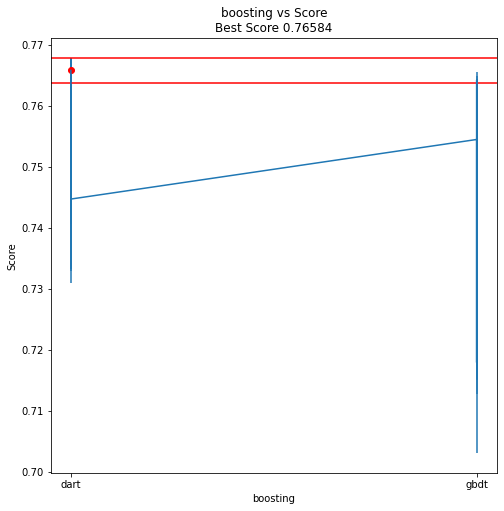

In [146]:
GridSearch_table_plot(clf,"boosting",negative=False,display_all_params=True)

In [159]:
joblib.dump(clf, 'gscv_results.pkl')

['gscv_results.pkl']

In [162]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# sample usage
save_object(clf, 'gscv_results.pkl')

In [164]:
test = pickle.load(open('gscv_results.pkl','rb'))

In [165]:
print(test.best_estimator_)

LGBMClassifier(bagging_fraction=1, boosting='dart', feature_fraction=1,
               is_unbalance=True, max_depth=8, metric='auc', num_iterations=500,
               num_leaves=16, objective='binary')
